In [1]:
import numpy as np
import regex as re
import pandas as pd
import gc
import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import string
import nltk as nlp
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors, Phrases
#from gensim.test.utils import common_texts
#from matplotlib.pyplot as plt
#from collections import Counter #like map but worse cuz it senses only the tally --> not for computation :(
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns

In [3]:
from google.colab import drive

drive.mount('/content/Mydrive')

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


In [4]:
dataframe = pd.read_csv('/content/Mydrive/MyDrive/Mini project/IMDB Dataset.csv')

In [ ]:
dataframe.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
dataframe.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
dataframe['sentiment'] = dataframe['sentiment'].replace('positive', 1)
dataframe['sentiment'] = dataframe['sentiment'].replace('negative', 0)
dataframe.head()
#in case of non-binary classes it makes more sense to use label encoder rather than replace

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Check for null and duplicates

In [6]:
dataframe.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
dataframe.duplicated().sum()

418

In [8]:
dataframe.drop_duplicates(subset='review', keep='first', inplace=True)

In [9]:
np.shape(dataframe)

(49582, 2)

In [10]:
dataframe.duplicated().sum()

0

In [11]:
dataframe.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Train Test Split

In [12]:
train, test = train_test_split(dataframe, test_size = 0.2, random_state = 156, shuffle=True)

In [13]:
train.head()

,review,sentiment
30420,I thought that this was an absolutely charming...,1
46571,I watched this show on the basis of it being t...,1
19101,There is only one film I can think of that mig...,1
14661,"Let's see... a couple dozen Gary Larson gags, ...",0
16681,"I have seen this wonderful production, and I w...",1


In [14]:
test.head()

,review,sentiment
10310,"Chaplin was great a silent comedian, but many ...",0
20472,This has got to be one of Australia's best pro...,1
31604,A surprising misfire from the usually reliable...,0
26404,Why do people bitch about this movie and not a...,1
30664,"Criticism of the film EVENING, based on the no...",1


In [15]:
del dataframe

In [16]:
X_train = train['review'].values
y_train = train['sentiment'].values
X_test = test['review'].values
y_test = test['sentiment'].values

In [17]:
del train, test

## Removing non-word characters from the dataset

In [18]:
def preprocess(text, pattern):
    if pattern=='[.]+':
        text = re.sub(pattern, '. ', text)
    elif pattern =="[']" or pattern == '[_]+':
        text =  re.sub(pattern, ' ', text)
    else:
        text = re.sub(pattern, '', text)
    #print(text, '\n')
    return text

In [19]:
X_train = np.vectorize(preprocess)(X_train, '<[^>]*>') #remove markup
X_test = np.vectorize(preprocess)(X_test, '<[^>]*>') #remove markup

In [20]:
X_train = np.vectorize(preprocess)(X_train, '[.]+') #remove ... and replace with .
X_test = np.vectorize(preprocess)(X_test, '[.]+') #remove ... and replace with .

In [21]:
X_train = np.vectorize(preprocess)(X_train, '[0-9]+') #remove numbers and replace with none
X_test = np.vectorize(preprocess)(X_test, '[0-9]+') #remove numbers and replace with none

In [22]:
X_train = np.vectorize(preprocess)(X_train, '[,]+') #remove numbers and replace with none
X_test = np.vectorize(preprocess)(X_test, '[,]]+') #remove numbers and replace with none

In [23]:
X_train = np.vectorize(preprocess)(X_train, "[']") #remove ' and replace with 
X_test = np.vectorize(preprocess)(X_test, "[']") #remove ' and replace with 

In [24]:
X_train = np.vectorize(preprocess)(X_train, "[_]+") #remove ' and replace with 
X_test = np.vectorize(preprocess)(X_test, "[_]+") #remove ' and replace with _

In [25]:
X_train = np.vectorize(preprocess)(X_train, '[^\w\s]*') #remove everything that's not word space
X_test = np.vectorize(preprocess)(X_test, '[^\w\s]*') #remove everything that's not word space
print(X_train[0])

I thought that this was an absolutely charming movie centering around the lives of MaryKate s and Ashley s characters Sam and Emma Stanton They are both trying to make both themselves and their parents happy but unfortunately it s just not that easy for them to actually do I thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then I m sure that you ll agree with me here If you haven t seen this movie yet then I say you really missedout big time and that you should definitely take the time out to see it now This movie is a real winner Sincerely Rick Morris


In [ ]:
gc.collect()

448

In [ ]:
X_train[0]

'I thought that this was an absolutely charming movie centering around the lives of MaryKate s and Ashley s characters Sam and Emma Stanton They are both trying to make both themselves and their parents happy but unfortunately it s just not that easy for them to actually do I thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then I m sure that you ll agree with me here If you haven t seen this movie yet then I say you really missedout big time and that you should definitely take the time out to see it now This movie is a real winner Sincerely Rick Morris'

In [ ]:
X_test[0]

'Chaplin was great a silent comedian but many silent era stars fell when the public heard their voices in the first talkies  In my opinion Chaplin s voice simply did not fit his silent characters that made him rich and famous  His career never recovered when sound came to film  Contrary to most of the reviews I have read Chaplin s lifestyle and politics did not help his popularity with the average viewer who expected to be entertained by Chaplin the comedian and not spend their entertainment dollar watching Chaplin s political commentary Despite Chaplin s awards and knighthood I would take exception to his contributions to humanity  The Great Dictator was made at the same time Stalin s brutal dictatorship was having it s show trials and both Dictators signed the agreement that lead to invasion of Poland by both Dictators  WWII started in an attempt to save Poland  The Nazi s were defeated in  years but Poland disappeared as a sovereign country  This happened during the time this film w

In [26]:
X_train = [sentence.lower() for sentence in X_train] #make it lower
print(X_train[0])
X_test = [sentence.lower() for sentence in X_test] #make it lower

i thought that this was an absolutely charming movie centering around the lives of marykate s and ashley s characters sam and emma stanton they are both trying to make both themselves and their parents happy but unfortunately it s just not that easy for them to actually do i thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then i m sure that you ll agree with me here if you haven t seen this movie yet then i say you really missedout big time and that you should definitely take the time out to see it now this movie is a real winner sincerely rick morris


In [ ]:
count = CountVectorizer()
bag = count.fit_transform(X_train)
len(count.vocabulary_) #counting unique words

130984

In [27]:
reviews = []
reviews_ = []

In [28]:
nlp.download('stopwords')
nlp.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
stop = set(stopwords.words('english'))

In [30]:
lemmatizer = WordNetLemmatizer()
nlp.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [31]:
def lemmatization(text, isTrain):
    text_ = word_tokenize(text)
    tokens = []
    for word in text_:
        if word not in stop:
            tokens.append(lemmatizer.lemmatize(word))
    if isTrain:
      reviews.append(tokens)
    else:
     reviews_.append(tokens)
    text = ' '.join(tokens)
    #print(reviews[0])
    #print(reviews_[0])
    return text

In [ ]:
lemmatizer.lemmatize("bats")

'bat'

In [ ]:
lemmatizer.lemmatize("loving")

'loving'

In [32]:
X_train = np.vectorize(lemmatization)(X_train, True)
X_test = np.vectorize(lemmatization)(X_test, False)
print(X_train[0])

thought absolutely charming movie centering around life marykate ashley character sam emma stanton trying make parent happy unfortunately easy actually thought utterly charming sweet movie real fan marvelous young lady sure agree seen movie yet say really missedout big time definitely take time see movie real winner sincerely rick morris


In [ ]:
X_test[0]

'chaplin great silent comedian many silent era star fell public heard voice first talkie opinion chaplin voice simply fit silent character made rich famous career never recovered sound came film contrary review read chaplin lifestyle politics help popularity average viewer expected entertained chaplin comedian spend entertainment dollar watching chaplin political commentary despite chaplin award knighthood would take exception contribution humanity great dictator made time stalin brutal dictatorship show trial dictator signed agreement lead invasion poland dictator wwii started attempt save poland nazi defeated year poland disappeared sovereign country happened time film made investigation hollywood federal government chaplin included joe stalin satirein addition including italian dictator perhaps would le criticism politics politician soviet mistreatment jew dissident exceeded nazi time number judged simply film many gag topical understood younger viewer know goebbels goring mussolini

In [33]:
reviews.pop(0)
reviews_.pop(0)
print()

In [34]:
X_train = np.array(reviews)
X_test = np.array(reviews_)
del reviews, reviews_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

39665
9917
39665
9917


In [ ]:
print(X_train[0])
print(X_test[0])

['thought', 'absolutely', 'charming', 'movie', 'centering', 'around', 'life', 'marykate', 'ashley', 'character', 'sam', 'emma', 'stanton', 'trying', 'make', 'parent', 'happy', 'unfortunately', 'easy', 'actually', 'thought', 'utterly', 'charming', 'sweet', 'movie', 'real', 'fan', 'marvelous', 'young', 'lady', 'sure', 'agree', 'seen', 'movie', 'yet', 'say', 'really', 'missedout', 'big', 'time', 'definitely', 'take', 'time', 'see', 'movie', 'real', 'winner', 'sincerely', 'rick', 'morris']
['chaplin', 'great', 'silent', 'comedian', 'many', 'silent', 'era', 'star', 'fell', 'public', 'heard', 'voice', 'first', 'talkie', 'opinion', 'chaplin', 'voice', 'simply', 'fit', 'silent', 'character', 'made', 'rich', 'famous', 'career', 'never', 'recovered', 'sound', 'came', 'film', 'contrary', 'review', 'read', 'chaplin', 'lifestyle', 'politics', 'help', 'popularity', 'average', 'viewer', 'expected', 'entertained', 'chaplin', 'comedian', 'spend', 'entertainment', 'dollar', 'watching', 'chaplin', 'polit

In [41]:
bigrams = Phrases(X_train)

In [42]:
trigrams = Phrases(sentences=bigrams[X_train])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
print(bigrams)
print(trigrams)

Phrases<2591773 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
Phrases<2819560 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
trigrams_model = Word2Vec(sentences = trigrams[bigrams[X_train]], size = 256, min_count=3, window=5, workers=4)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2021-10-17 10:16:31,940 : INFO : collecting all words and their counts
2021-10-17 10:16:31,944 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-10-17 10:16:43,158 : INFO : PROGRESS: at sentence #10000, processed 1050148 words, keeping 75597 word types
2021-10-17 10:16:55,266 : INFO : PROGRESS: at sentence #20000, processed 2098624 words, keeping 103318 word types
2021-10-17 10:17:07,123 : INFO : PROGRESS: at sentence #30000, processed 3153433 words, keeping 124604 word types
2021-10-17 10:17:18,586 : INFO : collected 142599 word types from a corpus of 4160212 raw words and 39665 sentences
2021-10-17 10:17:18,591 : INFO : Loading a fresh vocabulary
2021-10-17 10:17:19,000 : INFO : effective_min_count=3 retains 631

In [ ]:
len(trigrams_model.wv.vocab)

63134

In [35]:
#need to save model here
trigrams_model.wv.save_word2vec_format('/content/Mydrive/MyDrive/Mini project/word2vec/word_embeddings_trigram_lem.txt')

NameError: ignored

In [36]:
trigrams_model = KeyedVectors.load_word2vec_format('/content/Mydrive/MyDrive/Mini project/word2vec/word_embeddings_trigram_lem.txt', binary = False, unicode_errors = 'ignore')

In [ ]:
trigrams_model.similarity('say', 'may')

0.2854957

In [ ]:
trigrams_model.similarity('saw', 'say')

0.21409628

In [ ]:
trigrams_model.similarity('happy', 'unfortunate')

0.26045936

In [ ]:
trigrams_model.similarity('gangsta', 'latino')

0.6988027

In [ ]:
gc.collect()

247

## vectorization

In [ ]:
len(trigrams_model.wv.vocab)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


63134

In [ ]:
list(trigrams_model.wv.vocab.keys()).index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


<function list.index>

In [ ]:
trigrams_model.wv.vocab.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


dict_keys(['movie', 'film', 'one', 'like', 'good', 'character', 'would', 'really', 'time', 'even', 'get', 'story', 'make', 'see', 'also', 'great', 'scene', 'people', 'way', 'well', 'show', 'much', 'think', 'bad', 'thing', 'could', 'know', 'made', 'life', 'first', 'watch', 'go', 'many', 'actor', 'say', 'two', 'end', 'never', 'love', 'plot', 'still', 'little', 'work', 'acting', 'find', 'look', 'part', 'seen', 'something', 'take', 'lot', 'best', 'better', 'come', 'actually', 'give', 'director', 'man', 'play', 'want', 'another', 'going', 'funny', 'real', 'woman', 'guy', 'performance', 'thought', 'however', 'though', 'fact', 'watching', 'got', 'nothing', 'seems', 'ever', 'back', 'quite', 'may', 'role', 'girl', 'always', 'point', 'original', 'interesting', 'world', 'enough', 'right', 'kind', 'least', 'u', 'horror', 'day', 'comedy', 'saw', 'script', 'feel', 'year', 'without', 'kid', 'might', 'set', 'rather', 'music', 'probably', 'idea', 'since', 'bit', 'new', 'family', 'played', 'friend', 'al

In [ ]:
trigrams_model.wv.vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(63134, 256)

In [37]:
def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review))) 
    #for review in data:
      #print(review)
     # word_map = []
      #for word in review:
       # if vocab.get(word, None) is not None:
          
      #print(word_map)
    vectorized = list(map(encode, data))
  
    print(vectorized[2])
    #print('Vectorize sentences... (done)')
    return vectorized

In [38]:
 def get_mean():
    review_length = []
    for review in X_train:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))
maxim = get_mean()
print(maxim)

117


In [39]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

39665
9917
39665
9917


In [43]:
X_train = vectorize_data(trigrams[bigrams[X_train]], vocab = trigrams_model.wv.vocab)
X_test = vectorize_data(trigrams[bigrams[X_test]], vocab = trigrams_model.wv.vocab)
#X_train_pad = pad_sequences(sequences=X_train, , maxlen = maxim, padding='post', truncating='post')
#X_test_token = token_tensor.texts_to_sequences(X_test)
#X_test_pad = pad_sequences(X_test_token, maxlen = maxim, padding='post', truncating='post')

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[2, 1, 22, 100, 4, 52, 2, 53, 10748, 7864, 15418, 6710, 68, 25367, 51, 30, 202, 779, 8736, 15418, 6710, 317, 7864, 1719, 1275, 62, 1122, 68, 22, 2304, 3305, 39131, 171, 2750, 14, 9388, 336, 24, 87, 76, 7864, 1330, 7864, 123, 2017, 1561, 1, 248, 7864, 925, 3305, 1071, 87, 2750, 1588, 208, 2398, 1366, 12348, 3609, 3305, 411, 7864, 547, 20807, 2750, 8, 49, 7864, 1561, 141, 207, 1855, 7864, 239, 122, 220, 690, 62, 296, 130, 571, 2491, 683, 30576, 135, 38, 15, 1789, 143, 34, 9057, 536]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[1427, 8036, 37103, 28740, 479, 410, 5233, 364, 33820, 2919, 62, 5609, 9, 426, 141, 26017, 46792, 14098, 31016, 299, 66, 304, 1720, 171, 45, 12150, 12, 842, 2503, 227, 93, 176]


In [44]:
X_train_pad = pad_sequences(sequences=X_train, maxlen=maxim, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences=X_test, maxlen=maxim, padding='post', truncating='post')

In [ ]:
print(X_train_pad[0])
print(X_test_pad[1])

[   67   477   894     0 32893    28 24002     5  1449  3632 26850  2361
   453   533   259   629    54    67  1154   894   811     0    63   114
  2402  5783   133   738    47     0   125    34     7   142     8   258
    49     8    13     0 26851  7045  3528  3870     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]
[   72     2  2376    51   278   246  2690   320    27   117    20   804
  1501 49689  1872   295   158   160  1018 12805  4183    15   263     7
  1052  1501   807   103   165   299   117 41042   314   257  2709  5581
   271   238     2  1587   912  3022  1121 22524   257    70 19528  

In [ ]:
print(len(X_test_pad))
print(len(y_test))

9917
9917


## models

### simple rnn 0

In [ ]:
simple_rnn_0 = Sequential()
simple_rnn_0.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                           input_length = maxim,
                           weights = [trigrams_model.wv.vectors],
                           trainable=False))
simple_rnn_0.add(SimpleRNN(128, recurrent_dropout=0.1))
simple_rnn_0.add(Dropout(0.25))
simple_rnn_0.add(Dense(64))
simple_rnn_0.add(Dropout(0.3))
simple_rnn_0.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
simple_rnn_0.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
simple_rnn_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 117, 256)          16162304  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,219,905
Trainable params: 57,601
Non-trainable params: 16,162,304
_____________________________________

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/Mini project/models/simple_rnn_0.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2021-10-16 14:20:40,356 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
simple_rnn_history_0 = simple_rnn_0.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=50,
                                 callbacks=[checkpoint])

Epoch 1/50
589/589 [==============================] - 55s 91ms/step - loss: 0.7316 - accuracy: 0.5265 - val_loss: 0.6792 - val_accuracy: 0.5585

Epoch 00001: val_accuracy improved from -inf to 0.55847, saving model to /content/Mydrive/MyDrive/Mini project/models/simple_rnn_0.h5
Epoch 2/50
589/589 [==============================] - 53s 91ms/step - loss: 0.6875 - accuracy: 0.5474 - val_loss: 0.6895 - val_accuracy: 0.5398

Epoch 00002: val_accuracy did not improve from 0.55847
Epoch 3/50
589/589 [==============================] - 53s 90ms/step - loss: 0.6883 - accuracy: 0.5302 - val_loss: 0.6806 - val_accuracy: 0.5565

Epoch 00003: val_accuracy did not improve from 0.55847
Epoch 4/50
589/589 [==============================] - 53s 90ms/step - loss: 0.6815 - accuracy: 0.5493 - val_loss: 0.6735 - val_accuracy: 0.5554

Epoch 00004: val_accuracy did not improve from 0.55847
Epoch 5/50
589/589 [==============================] - 53s 90ms/step - loss: 0.6749 - accuracy: 0.5580 - val_loss: 0.6899 

In [ ]:
del simple_rnn_0
gc.collect()

2272

In [45]:
simple_rnn_0 = load_model('/content/Mydrive/MyDrive/Mini project/models/simple_rnn_0.h5')

#### metrics

In [46]:
y_pred = simple_rnn_0.predict(X_test_pad)

In [47]:
y_pred

array([[0.5845971],
       [0.6862086],
       [0.6948147],
       ...,
       [0.6948147],
       [0.6948147],
       [0.708362 ]], dtype=float32)

In [48]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [49]:
accuracy_score(y_test, y_pred)

0.7158414843198548

#### confusion matrix

In [50]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[2821 2166]
 [ 652 4278]]


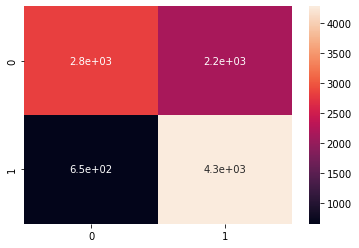

In [51]:
sns.heatmap(cf_matrix, annot=True)

#### classificationn report

In [52]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.81      0.57      0.67      4987
           1       0.66      0.87      0.75      4930

    accuracy                           0.72      9917
   macro avg       0.74      0.72      0.71      9917
weighted avg       0.74      0.72      0.71      9917



### lstm 0

In [ ]:
lstm_0 = Sequential()
lstm_0.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                          input_length = maxim,
                          weights = [trigrams_model.wv.vectors],
                          trainable=False))
lstm_0.add(LSTM(128, recurrent_dropout=0.1))
lstm_0.add(Dropout(0.25))
lstm_0.add(Dense(64))
lstm_0.add(Dropout(0.3))
lstm_0.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
lstm_0.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
lstm_0.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 117, 256)          16162304  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 16,367,745
Trainable params: 205,441
Non-trainable params: 16,162,304
___________________________________

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/Mini project/models/lstm_0.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2021-10-16 16:32:07,976 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
lstm_history_0 = lstm_0.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=50,
                                 callbacks=[checkpoint])

Epoch 1/50
589/589 [==============================] - 228s 388ms/step - loss: 0.4033 - accuracy: 0.8293 - val_loss: 0.3614 - val_accuracy: 0.8422

Epoch 00001: val_accuracy improved from -inf to 0.84224, saving model to /content/Mydrive/MyDrive/Mini project/models/lstm_0.h5
Epoch 2/50
589/589 [==============================] - 229s 388ms/step - loss: 0.3454 - accuracy: 0.8522 - val_loss: 0.3914 - val_accuracy: 0.8226

Epoch 00002: val_accuracy did not improve from 0.84224
Epoch 3/50
589/589 [==============================] - 228s 388ms/step - loss: 0.3235 - accuracy: 0.8641 - val_loss: 0.3427 - val_accuracy: 0.8453

Epoch 00003: val_accuracy improved from 0.84224 to 0.84526, saving model to /content/Mydrive/MyDrive/Mini project/models/lstm_0.h5
Epoch 4/50
589/589 [==============================] - 229s 388ms/step - loss: 0.3063 - accuracy: 0.8717 - val_loss: 0.3285 - val_accuracy: 0.8639

Epoch 00004: val_accuracy improved from 0.84526 to 0.86391, saving model to /content/Mydrive/MyDri

In [ ]:
del lstm_0
gc.collect()

24728

In [ ]:
lstm_0 = load_model('/content/Mydrive/MyDrive/Mini project/models/lstm_0.h5')

#### metrics

In [ ]:
y_pred = lstm_0.predict(X_test_pad)

In [ ]:
y_pred

array([[0.7716007 ],
       [0.98873913],
       [0.23696426],
       ...,
       [0.64671445],
       [0.97626805],
       [0.98983115]], dtype=float32)

In [ ]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.8649793284259353

#### confusion matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[4146  841]
 [ 498 4432]]


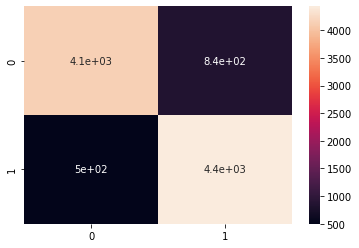

In [ ]:
sns.heatmap(cf_matrix, annot=True)

#### classification report

In [ ]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      4987
           1       0.84      0.90      0.87      4930

    accuracy                           0.86      9917
   macro avg       0.87      0.87      0.86      9917
weighted avg       0.87      0.86      0.86      9917



### simple rnn 1

In [ ]:
simple_rnn_1 = Sequential()
simple_rnn_1.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                           input_length = maxim,
                           weights = [trigrams_model.wv.vectors],
                           trainable=False))
simple_rnn_1.add(SimpleRNN(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
simple_rnn_1.add(SimpleRNN(128, recurrent_dropout=0.1))
simple_rnn_1.add(Dropout(0.25))
simple_rnn_1.add(Dense(64))
simple_rnn_1.add(Dropout(0.3))
simple_rnn_1.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
simple_rnn_1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
simple_rnn_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 117, 256)          16162304  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 117, 128)          49280     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/Mini project/models/simple_rnn_1.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2021-10-17 03:47:21,340 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
simple_rnn_history_1 = simple_rnn_1.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=50,
                                 callbacks=[checkpoint])

Epoch 1/50
589/589 [==============================] - 135s 224ms/step - loss: 0.7363 - accuracy: 0.5163 - val_loss: 0.6884 - val_accuracy: 0.5408

Epoch 00001: val_accuracy improved from -inf to 0.54083, saving model to /content/Mydrive/MyDrive/Mini project/models/simple_rnn_1.h5
Epoch 2/50
589/589 [==============================] - 130s 221ms/step - loss: 0.6963 - accuracy: 0.5237 - val_loss: 0.6865 - val_accuracy: 0.5408

Epoch 00002: val_accuracy did not improve from 0.54083
Epoch 3/50
589/589 [==============================] - 132s 224ms/step - loss: 0.6910 - accuracy: 0.5187 - val_loss: 0.6930 - val_accuracy: 0.4929

Epoch 00003: val_accuracy did not improve from 0.54083
Epoch 4/50
589/589 [==============================] - 129s 220ms/step - loss: 0.6917 - accuracy: 0.5169 - val_loss: 0.6937 - val_accuracy: 0.4819

Epoch 00004: val_accuracy did not improve from 0.54083
Epoch 5/50
589/589 [==============================] - 132s 224ms/step - loss: 0.6939 - accuracy: 0.5015 - val_los

In [ ]:
del simple_rnn_1
gc.collect()

41410

In [ ]:
simple_rnn_1 = load_model('/content/Mydrive/MyDrive/Mini project/models/simple_rnn_1.h5')

#### metrics

In [ ]:
y_pred = simple_rnn_1.predict(X_test_pad)

In [ ]:
y_pred

array([[0.6392239 ],
       [0.70905954],
       [0.37476435],
       ...,
       [0.70873916],
       [0.70873916],
       [0.69894946]], dtype=float32)

In [ ]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.7424624382373701

#### confusion matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[3521 1466]
 [1088 3842]]


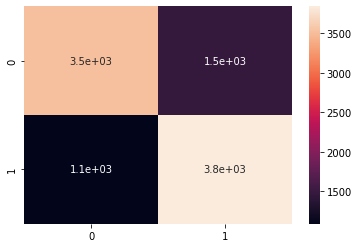

In [ ]:
sns.heatmap(cf_matrix, annot=True)

#### classification report

In [ ]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      4987
           1       0.72      0.78      0.75      4930

    accuracy                           0.74      9917
   macro avg       0.74      0.74      0.74      9917
weighted avg       0.74      0.74      0.74      9917



### simple rnn 2

In [ ]:
simple_rnn_2 = Sequential()
simple_rnn_2.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                           input_length = maxim,
                           weights = [trigrams_model.wv.vectors],
                           trainable=False))
simple_rnn_2.add(SimpleRNN(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
simple_rnn_2.add(SimpleRNN(64, recurrent_dropout=0.1))
simple_rnn_2.add(Dropout(0.25))
simple_rnn_2.add(Dense(32))
simple_rnn_2.add(Dropout(0.3))
simple_rnn_2.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
simple_rnn_2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
simple_rnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 117, 256)          16162304  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 117, 128)          49280     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/Mini project/models/simple_rnn_2.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2021-10-18 06:05:23,011 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
simple_rnn_history_2 = simple_rnn_2.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=20,
                                 callbacks=[checkpoint])

Epoch 1/20
589/589 [==============================] - 107s 179ms/step - loss: 0.7214 - accuracy: 0.5307 - val_loss: 0.6746 - val_accuracy: 0.5645

Epoch 00001: val_accuracy improved from -inf to 0.56452, saving model to /content/Mydrive/MyDrive/Mini project/models/simple_rnn_2.h5
Epoch 2/20
589/589 [==============================] - 105s 179ms/step - loss: 0.6967 - accuracy: 0.5196 - val_loss: 0.6933 - val_accuracy: 0.5126

Epoch 00002: val_accuracy did not improve from 0.56452
Epoch 3/20
589/589 [==============================] - 105s 179ms/step - loss: 0.6851 - accuracy: 0.5379 - val_loss: 0.6689 - val_accuracy: 0.6003

Epoch 00003: val_accuracy improved from 0.56452 to 0.60030, saving model to /content/Mydrive/MyDrive/Mini project/models/simple_rnn_2.h5
Epoch 4/20
589/589 [==============================] - 105s 179ms/step - loss: 0.6620 - accuracy: 0.6125 - val_loss: 0.6688 - val_accuracy: 0.5701

Epoch 00004: val_accuracy did not improve from 0.60030
Epoch 5/20
589/589 [===========

In [ ]:
del simple_rnn_2
gc.collect()

12162

In [ ]:
simple_rnn_2 = load_model('/content/Mydrive/MyDrive/Mini project/models/simple_rnn_2.h5')

#### metrics

In [ ]:
y_pred = simple_rnn_2.predict(X_test_pad)

In [ ]:
y_pred

array([[0.5221243 ],
       [0.58751905],
       [0.5584179 ],
       ...,
       [0.5584179 ],
       [0.5584179 ],
       [0.5911166 ]], dtype=float32)

In [ ]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.5963497025310074

#### confusion matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[1541 3446]
 [ 557 4373]]


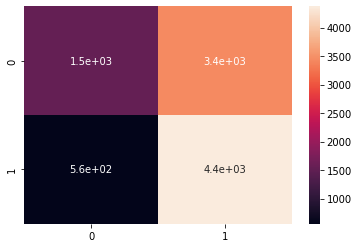

In [ ]:
sns.heatmap(cf_matrix, annot=True)

#### classification report

In [ ]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.73      0.31      0.44      4987
           1       0.56      0.89      0.69      4930

    accuracy                           0.60      9917
   macro avg       0.65      0.60      0.56      9917
weighted avg       0.65      0.60      0.56      9917

